In [1]:
import numpy as np
import sys
import torch
torch.set_num_threads(2)

from functools import partial

from kusanagi.shell import cartpole
from kusanagi.base import ExperienceDataset, apply_controller
from kusanagi.ghost.control import RandPolicy

sys.path.append('..')
from prob_mbrl import algorithms, models, train_regressor, losses, utils

In [2]:
def forward(states, actions, dynamics, measurement_noise=True,
            z_states=None, z_rewards=None,**kwargs):
    
    (deltas, deltas_std), (rewards, rewards_std) = dyn(
        (states, actions), separate_outputs=True, **kwargs)
    next_states = states + deltas
    if measurement_noise:
        z1 = z_states if z_states is not None else torch.randn_like(next_states)
        next_states += z1*deltas_std
        z2 = z_rewards if z_rewards is not None else torch.randn(next_states.shape[0], 1)
        rewards += z2*rewards_std
    return next_states, rewards

In [3]:
env = cartpole.Cartpole()
target = torch.tensor([0,0,0,np.pi]).float()
D = target.shape[-1]
U = 1
learn_reward=True
maxU = np.array([10.0])     
angle_dims = torch.tensor([3]).long()
target = utils.to_complex(target, angle_dims)
Da = target.shape[-1]
Q = torch.zeros(Da, Da).float()
Q[0, 0] = 1
Q[0, -2] = env.l
Q[-2, 0] = env.l
Q[-2, -2] = env.l**2
Q[-1, -1] = env.l**2
Q /= 0.1
def reward_func(states, target, Q, angle_dims):
    states = utils.to_complex(states, angle_dims)
    reward = losses.quadratic_saturating_loss(states, target, Q)
    return reward, torch.zeros_like(reward)

dynE = 2*(D+1) if learn_reward else 2*D
reward_func = None if learn_reward else partial(reward_func, target=target, Q=Q, angle_dims=angle_dims)
dyn = models.DynamicsModel(
    models.dropout_mlp(
        D+U, dynE, [200]*2,
        dropout_layers=[models.modules.CDropout(0.5)]*2,
        nonlin=torch.nn.ReLU), reward_func=reward_func).float()
pol = models.Policy(
    models.dropout_mlp(
        D, U, output_nonlin=torch.nn.Tanh,
        dropout_layers=[models.modules.BDropout(0.5)]*2), maxU).float()
randpol = RandPolicy(maxU)
exp = ExperienceDataset()
params = filter(lambda p: p.requires_grad, pol.parameters())
opt = torch.optim.Adam(params, 1e-3, amsgrad=True)

forward_fn = partial(forward, dynamics=dyn)


[2018-06-29 18:20:37.233401] Experience > Initialising new experience dataset


In [4]:
#%matplotlib qt
def cb(*args, **kwargs):
    env.render()

H = 25
N_particles = 100
for rand_it in range(1):
    ret = apply_controller(env, randpol, H, callback=None)
    exp.append_episode(*ret)

[2018-06-29 18:20:37.246814] apply_controller > Starting run
[2018-06-29 18:20:37.248221] apply_controller > Running for 2.500000 seconds
[2018-06-29 18:20:37.384475] apply_controller > Done. Stopping robot. Value of run [24.939602]
[2018-06-29 18:20:37.385793] Cartpole > Stopping robot


[2018-06-29 18:20:37.408391] apply_controller > Starting run
[2018-06-29 18:20:37.410245] apply_controller > Running for 2.500000 seconds
[2018-06-29 18:20:37.549041] apply_controller > Done. Stopping robot. Value of run [24.883495]
[2018-06-29 18:20:37.550277] Cartpole > Stopping robot


log-likelihood of data: 1.204847: 100%|█████████▉| 998/1000 [00:07<00:00, 129.98it/s] 


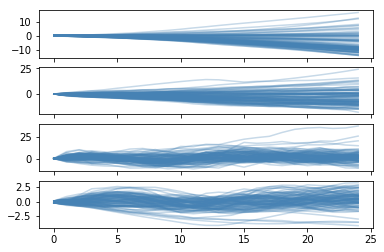

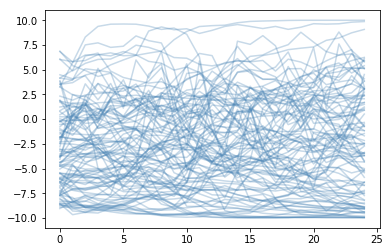

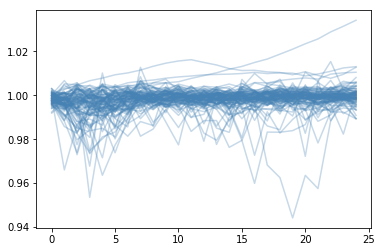

/home/juancamilog/miniconda2/lib/python2.7/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Accumulated costs: 0.997009:   0%|          | 1/1000 [00:00<01:47,  9.28it/s]

Policy search iteration 1


Accumulated costs: 0.987323: 100%|██████████| 1000/1000 [02:39<00:00,  6.27it/s]


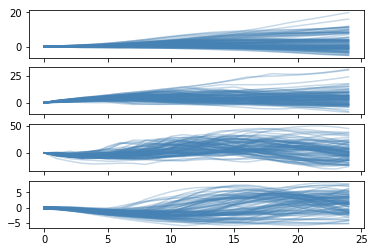

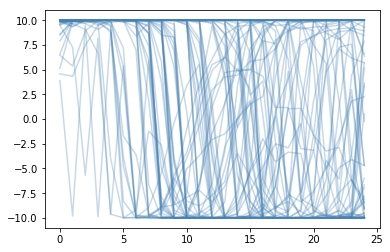

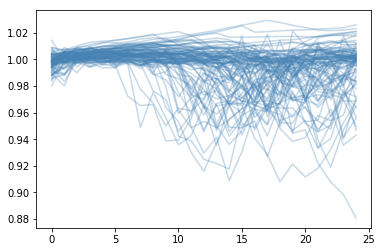

[2018-06-29 18:23:29.621755] apply_controller > Starting run
[2018-06-29 18:23:29.623551] apply_controller > Running for 2.500000 seconds
[2018-06-29 18:23:29.796456] apply_controller > Done. Stopping robot. Value of run [24.953285]
[2018-06-29 18:23:29.798312] Cartpole > Stopping robot


log-likelihood of data: 3.927436: 100%|█████████▉| 999/1000 [00:08<00:00, 114.88it/s]


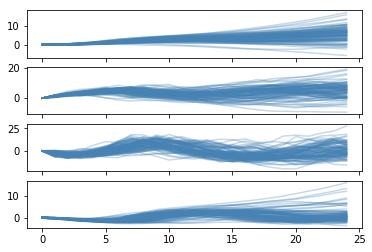

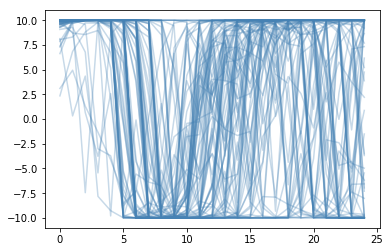

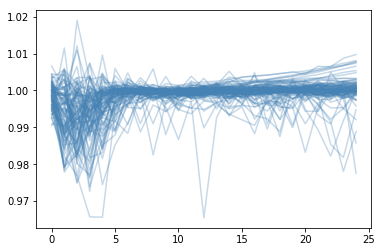

Accumulated costs: 0.998598:   0%|          | 1/1000 [00:00<01:42,  9.77it/s]

Policy search iteration 2


Accumulated costs: 0.989170: 100%|██████████| 1000/1000 [02:43<00:00,  6.12it/s]


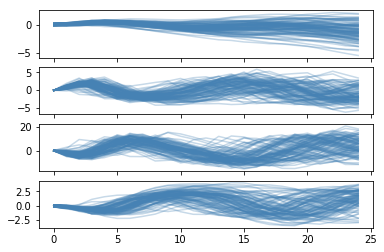

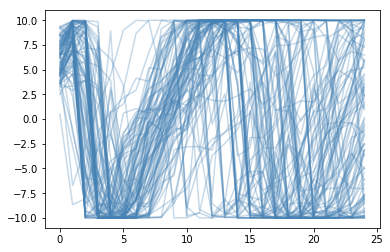

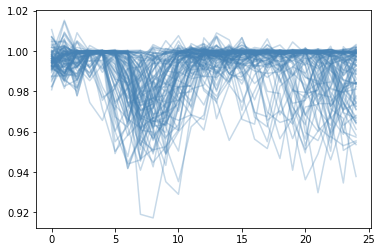

[2018-06-29 18:26:30.013415] apply_controller > Starting run
[2018-06-29 18:26:30.015584] apply_controller > Running for 2.500000 seconds
[2018-06-29 18:26:30.330976] apply_controller > Done. Stopping robot. Value of run [21.479435]
[2018-06-29 18:26:30.333053] Cartpole > Stopping robot


log-likelihood of data: 7.822685:  99%|█████████▉| 989/1000 [00:09<00:00, 102.71it/s]


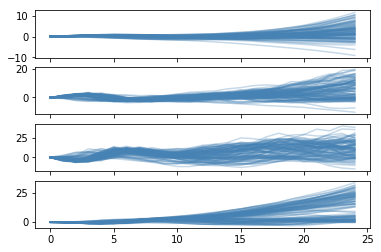

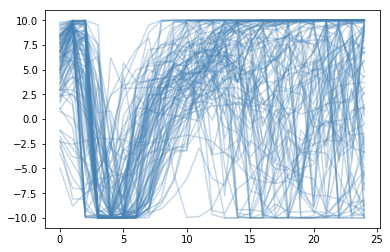

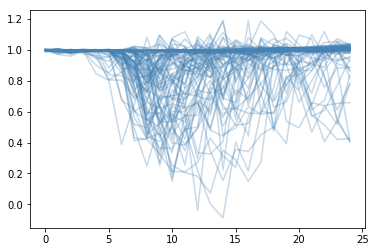

Accumulated costs: 0.955733:   0%|          | 1/1000 [00:00<01:40,  9.97it/s]

Policy search iteration 3


Accumulated costs: 0.726607: 100%|██████████| 1000/1000 [01:53<00:00,  8.80it/s]


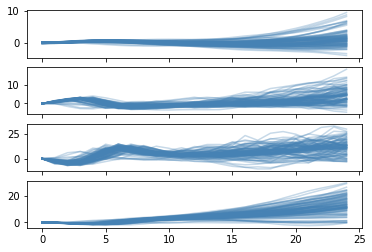

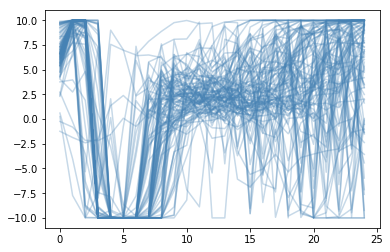

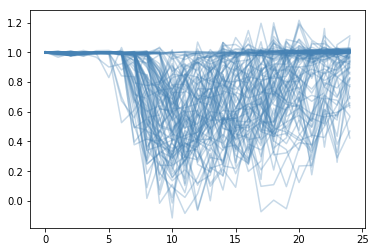

[2018-06-29 18:28:38.479677] apply_controller > Starting run
[2018-06-29 18:28:38.481294] apply_controller > Running for 2.500000 seconds
[2018-06-29 18:28:38.651101] apply_controller > Done. Stopping robot. Value of run [23.918339]
[2018-06-29 18:28:38.652359] Cartpole > Stopping robot


log-likelihood of data: 9.188950:  99%|█████████▉| 989/1000 [00:07<00:00, 127.23it/s]


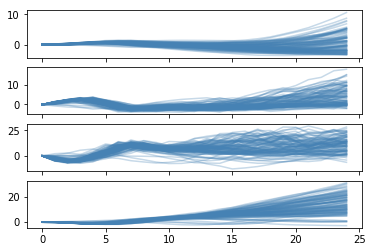

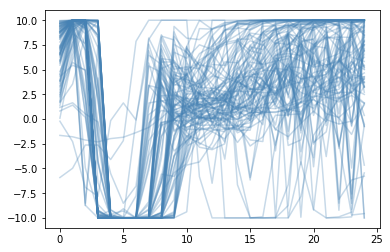

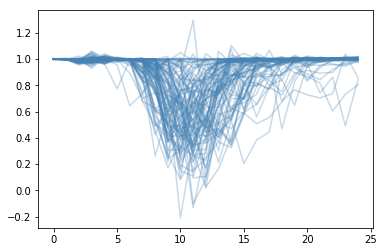

Accumulated costs: 0.901852:   0%|          | 2/1000 [00:00<01:34, 10.58it/s]

Policy search iteration 4


Accumulated costs: 0.744229: 100%|██████████| 1000/1000 [01:41<00:00,  9.82it/s]


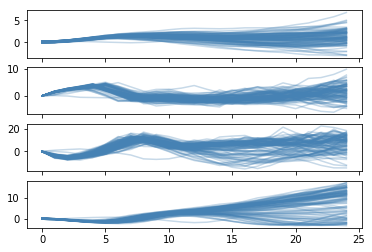

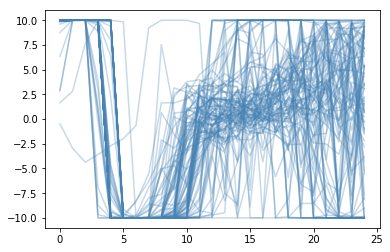

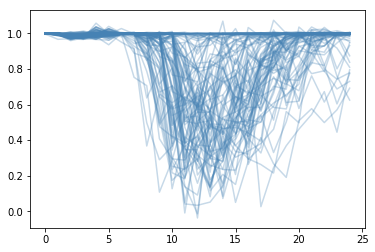

[2018-06-29 18:30:33.038048] apply_controller > Starting run
[2018-06-29 18:30:33.039493] apply_controller > Running for 2.500000 seconds
[2018-06-29 18:30:33.203791] apply_controller > Done. Stopping robot. Value of run [24.216192]
[2018-06-29 18:30:33.205187] Cartpole > Stopping robot


log-likelihood of data: 10.683717: 100%|█████████▉| 995/1000 [00:08<00:00, 121.11it/s]


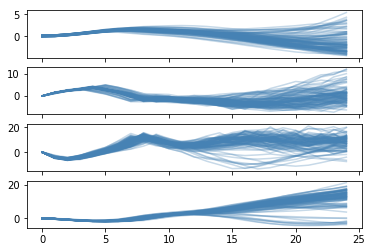

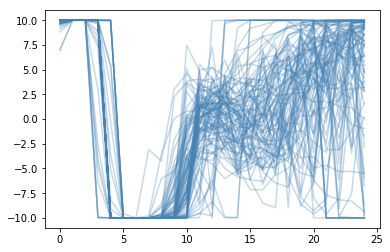

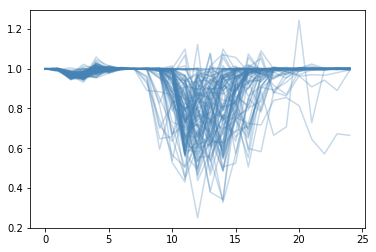

Accumulated costs: 0.965935:   0%|          | 1/1000 [00:00<01:53,  8.77it/s]

Policy search iteration 5


Accumulated costs: 0.849305: 100%|██████████| 1000/1000 [02:04<00:00,  8.05it/s]


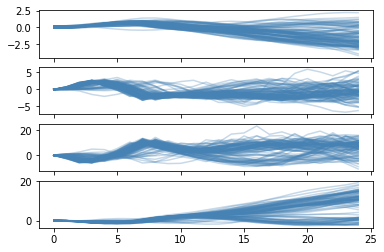

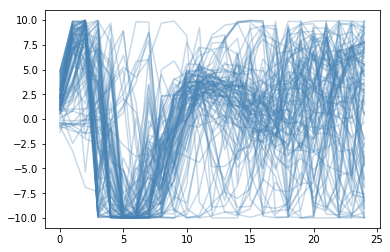

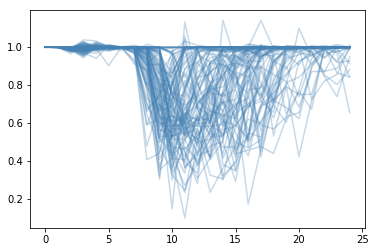

[2018-06-29 18:32:50.766735] apply_controller > Starting run
[2018-06-29 18:32:50.768386] apply_controller > Running for 2.500000 seconds
[2018-06-29 18:32:50.919373] apply_controller > Done. Stopping robot. Value of run [23.148487]
[2018-06-29 18:32:50.920722] Cartpole > Stopping robot


log-likelihood of data: 12.402506:  99%|█████████▉| 990/1000 [00:08<00:00, 114.20it/s]


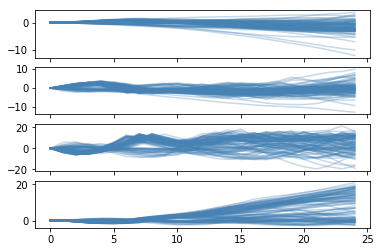

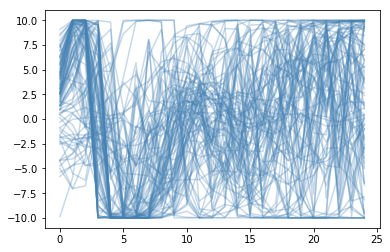

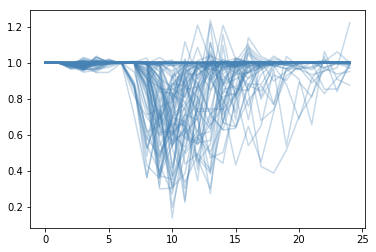

Accumulated costs: 0.937704:   0%|          | 1/1000 [00:00<01:45,  9.44it/s]

Policy search iteration 6


Accumulated costs: 0.867333: 100%|██████████| 1000/1000 [02:19<00:00,  7.19it/s]


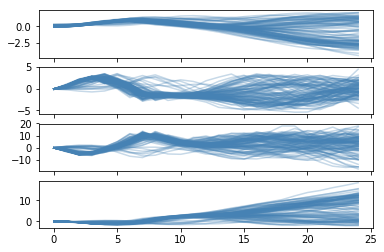

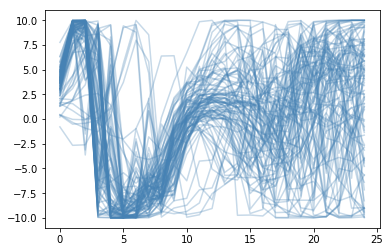

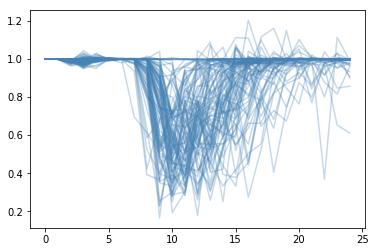

[2018-06-29 18:35:23.734782] apply_controller > Starting run
[2018-06-29 18:35:23.736344] apply_controller > Running for 2.500000 seconds
[2018-06-29 18:35:23.888368] apply_controller > Done. Stopping robot. Value of run [14.976544]
[2018-06-29 18:35:23.890002] Cartpole > Stopping robot


log-likelihood of data: 11.769225:  99%|█████████▉| 989/1000 [00:08<00:00, 111.20it/s]


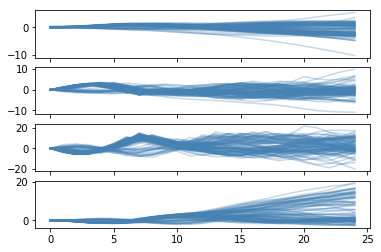

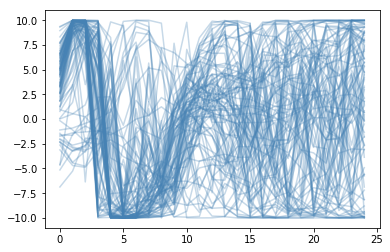

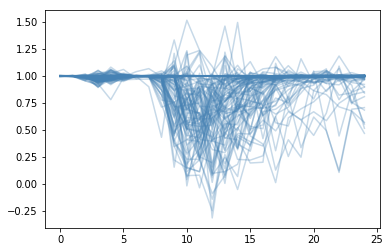

Accumulated costs: 0.918168:   0%|          | 2/1000 [00:00<01:38, 10.16it/s]

Policy search iteration 7


Accumulated costs: 0.550649: 100%|██████████| 1000/1000 [01:57<00:00,  8.53it/s]


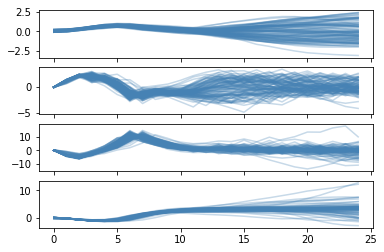

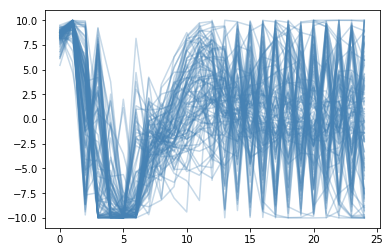

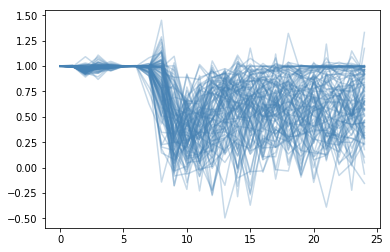

[2018-06-29 18:37:35.067558] apply_controller > Starting run
[2018-06-29 18:37:35.069060] apply_controller > Running for 2.500000 seconds
[2018-06-29 18:37:35.220272] apply_controller > Done. Stopping robot. Value of run [23.709843]
[2018-06-29 18:37:35.221490] Cartpole > Stopping robot


log-likelihood of data: 12.791673:  99%|█████████▉| 988/1000 [00:08<00:00, 118.82it/s]


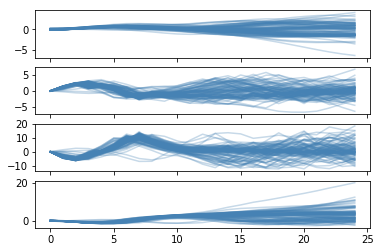

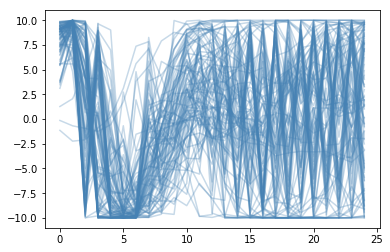

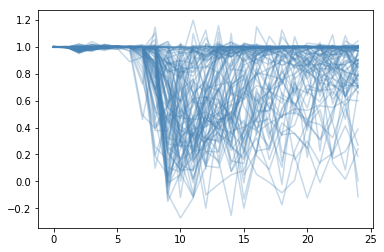

  0%|          | 0/1000 [00:00<?, ?it/s]

Policy search iteration 8


Accumulated costs: 0.443803:  19%|█▉        | 193/1000 [00:36<02:31,  5.31it/s]

In [ ]:
for ps_it in range(100):
    # apply policy
    ret = apply_controller(env, pol, H, callback=None)
    exp.append_episode(*ret)

    # train dynamics
    X, Y = exp.get_dynmodel_dataset(deltas=True, return_costs=learn_reward)
    dyn.set_dataset(torch.tensor(X).to(dyn.X.device).float(), torch.tensor(Y).to(dyn.X.device).float())  
    train_regressor(dyn, 1000, N_particles, True)
    x0 = torch.tensor(exp.sample_initial_state(N_particles)).to(dyn.X.device).float()
    x0 += 1e-2*x0.std(0)*torch.randn_like(x0)
    utils.plot_rollout(x0, forward_fn, pol, H)
    
    # train policy
    print "Policy search iteration %d" % (ps_it+1)
    algorithms.mc_pilco(x0, forward_fn, dyn, pol, H, opt, exp=exp,
             maximize=False, pegasus=True, mm_states=True,
             mm_rewards=True, angle_dims=angle_dims)
    utils.plot_rollout(x0, forward_fn, pol, H)
    